# Inducing inputs and Cloaking

Uses dataset: Females in the !Kung

Can I combined inducing inputs and cloaking

- use the alternative covariance matrix provided by the use of inducing inputs
- how to select inducing inputs (does picking cluster centroids do a good enough job?)

In [2]:
import dp4gp_datasets
import dp4gp
import random
import numpy as np
import GPy
import matplotlib.pyplot as plt
import dp4gp_histogram
import pandas as pd
%matplotlib inline

kung = dp4gp_datasets.load_kung()

X = kung[kung[:,3]==0,1:3]
y = kung[kung[:,3]==0,0:1]
sens = 100.0
epsilon = 1.0
delta = 0.01
middley = (np.max(y)+np.min(y))/2
y[y>middley+sens/2] = middley+sens/2
y[y<middley-sens/2] = middley-sens/2
#ysub = np.mean(y)
ysub = (max(y)+min(y))/2.0
y = y - ysub
ys_std = np.std(y)
y = y / ys_std
ac_sens = sens/ys_std

warning in stationary: failed to import cython module: falling back to numpy


(225, 287)
*
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Stopped before convergence
(3.8846795501345945, 3.2552472614374586, array([[ 1.05414524]]), 1.0, 0.0)
0
[  0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           6.66666667   6.66666667   6.66666667   6.66666667
   6.66666667   6.66666667   6.66666667   6.66666667   6.66666667
   6.66666667   6.66666667   6.66666667   6.66666667   6.66666667
   6.66666667  13.33333333  13.33333333  13.33333333  13.33333333
  13.33333333  13.33333333  13.33333333  13.33333333  13.33333333
  13.33333333  13.33333333  13.33333333  13.33333333  13.33333333
  13.33333333  20.          20.          20.          20.          20.          20.
  20.          20.          20.    

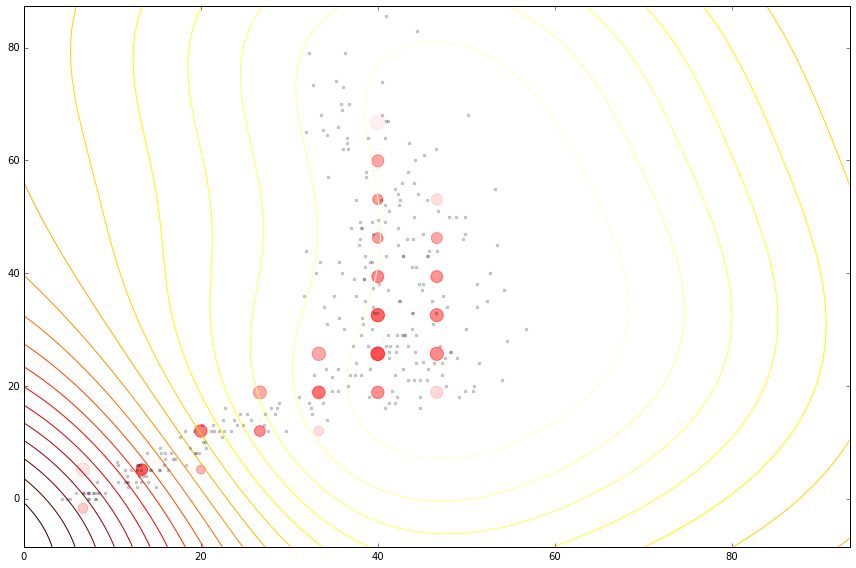

In [4]:


kern = GPy.kern.RBF(2.0,lengthscale=25.0,variance=1.0)
#model = GPy.models.GPRegression(X,y,kern,normalizer=None)
model = GPy.models.GPRegression(X,y,kern,normalizer=None)
model.Gaussian_noise = 0.3

dpgp = dp4gp.DPGP_cloaking(model,ac_sens,epsilon,delta)
Xtest = np.arange(-40,140,3)[:,None]


#plt.figure(figsize=[10,4]) #original
plt.figure(figsize=[12,8])

dpgp.plot(steps=15,plot_data = True,extent_lower={0:0},extent_upper={0:100},Nits=100,ys_mean=ysub,ys_std=ys_std,confidencescale=[1.0])
fig = plt.gcf()
fig.set_size_inches(12,8)

[[ 11.57007752   3.62280702]
 [ 42.9178609   25.79883721]
 [ 42.24165971  45.12714286]
 [ 24.57689029  13.025     ]
 [ 38.50028862  67.16470588]]
(225, 287)
*
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Stopped before convergence
(3.8846795501345945, 3.2552472614374586, array([[ 1.03206667]]), 1.0, 0.0)
0
[  0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           6.66666667   6.66666667   6.66666667   6.66666667
   6.66666667   6.66666667   6.66666667   6.66666667   6.66666667
   6.66666667   6.66666667   6.66666667   6.66666667   6.66666667
   6.66666667  13.33333333  13.33333333  13.33333333  13.33333333
  13.33333333  13.33333333  13.33333333  13.33333333  13.33333333
  13.33333333  13.33333333  13.33333333

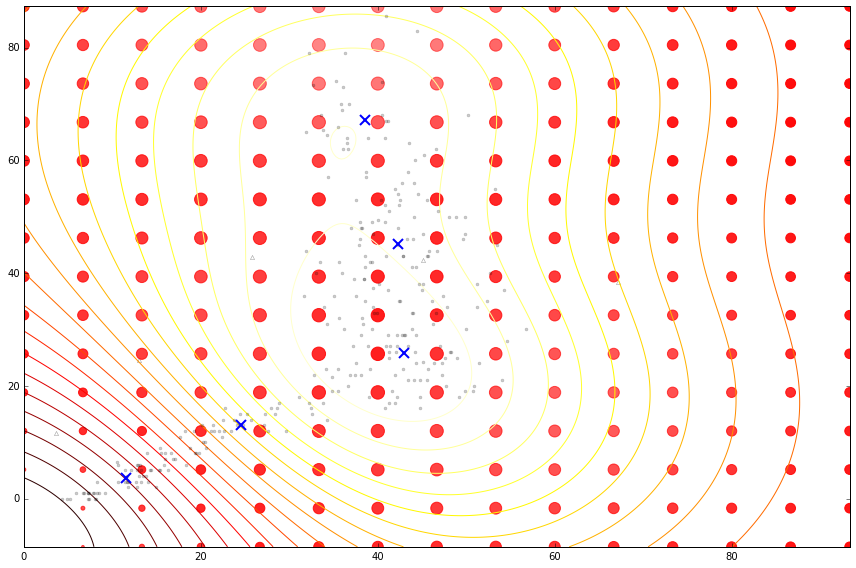

In [6]:
from sklearn.cluster import KMeans

kern = GPy.kern.RBF(2.0,lengthscale=25.0,variance=1.0)
#model = GPy.models.GPRegression(X,y,kern,normalizer=None)
inducinglocs = KMeans(n_clusters=5, random_state=0).fit(X).cluster_centers_
model = GPy.models.SparseGPRegression(X,y,kern,normalizer=None,Z=inducinglocs)
model.Gaussian_noise = 0.3

dpgp = dp4gp.DPGP_inducing_cloaking(model,ac_sens,epsilon,delta)
Xtest = np.arange(-40,140,3)[:,None]


#plt.figure(figsize=[10,4]) #original
plt.figure(figsize=[12,8])

dpgp.plot(steps=15, plot_data = True,extent_lower={0:0},extent_upper={0:100},Nits=100,ys_mean=ysub,ys_std=ys_std,confidencescale=[1.0])
plt.plot(inducinglocs[:,0],inducinglocs[:,1],'x',markersize=10,mew=2)
fig = plt.gcf()
fig.set_size_inches(12,8)

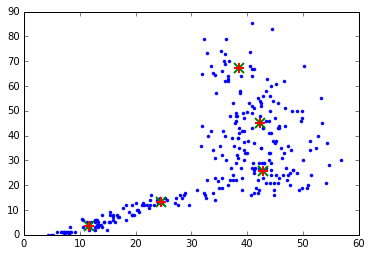

In [7]:
plt.plot(X[:,0],X[:,1],'.')
plt.plot(inducinglocs[:,0],inducinglocs[:,1],'x',markersize=10,mew=2)
plt.plot(dpgp.model.Z[:,0],dpgp.model.Z[:,1],'+r',markersize=10,mew=2)


I'm going to make this the development location for x-validation code

In [1]:
# http://scikit-learn.org/stable/developers/contributing.html#estimators


from sklearn.model_selection import cross_val_score

import numpy as np
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.cluster import KMeans

class DPCloaking(BaseEstimator):
    def __init__(self, kern=None, sensitivity=1.0, epsilon=1.0, delta=0.01, inducing=None):
        """
        kern = a GPy kernel, Default: uses a default 1d RBF kernel, with default hyperparameters if not specified.
        inducing = locations of inducing points, default to None - not using inducing points.
        """
        self.kern = kern
        self.sensitivity = sensitivity
        self.epsilon = epsilon
        self.delta = delta
        self.inducing = inducing
        
    def fit(self, X, y, **kwargs):    
        if self.kern is None:
            self.kern = GPy.kern.RBF(1.0)
        
        
        if self.inducing is None:
            self.model = GPy.models.GPRegression(X,y,kern,normalizer=None)
            self.dpgp = dp4gp.DPGP_cloaking(self.model,self.sensitivity,self.epsilon,self.delta)
        else:
            if isinstance(self.inducing, list):
                inducinglocs = self.inducing
            else:
                inducinglocs = KMeans(n_clusters=self.inducing, random_state=0).fit(X).cluster_centers_
            self.model = GPy.models.SparseGPRegression(X,y,kern,normalizer=None,Z=inducinglocs)
            self.dpgp = dp4gp.DPGP_inducing_cloaking(self.model,self.sensitivity,self.epsilon,self.delta)
        return self

    def predict(self, X, Nattempts=2, Nits=100):
        ypred,_,_= self.dpgp.draw_prediction_samples(X,Nattempts=Nattempts,Nits=Nits)
        return ypred
    
#    def get_params(self, deep=True):
#        return {"kern": self.kern, "sensitivity":self.sensitivity, "epsilon":self.epsilon, "delta":self.delta}

kern = GPy.kern.RBF(2.0,lengthscale=25.0,variance=1.0)
#scores_inducing = cross_val_score(DPCloaking(sensitivity=ac_sens,kern=kern.copy(),inducing = np.array([[0.0,20.0,40,50.0]]).T),X,y,scoring='neg_mean_squared_error',cv = 10)
scores_inducing = cross_val_score(DPCloaking(sensitivity=ac_sens,kern=kern.copy(),inducing = 5),X,y,scoring='neg_mean_squared_error',cv = 10)
#scores_inducing = {}
#for Nind in [1,5,25]:
#    scores_inducing[Nind] = cross_val_score(DPCloaking(sensitivity=ac_sens,kern=kern.copy(),inducing = 25),X,y,scoring='neg_mean_squared_error',cv = 10)

kern = GPy.kern.RBF(2.0,lengthscale=25.0,variance=1.0)
scores_normal = []
for it in range(1):
    scores_normal.extend(cross_val_score(DPCloaking(sensitivity=ac_sens,kern=kern.copy()),X,y,scoring='neg_mean_squared_error',cv = 10))

NameError: name 'GPy' is not defined

In [9]:
rmse_normal = ys_std*np.sqrt(-np.array(scores_normal))
rmse_inducing = ys_std*np.sqrt(-scores_inducing)

In [10]:
print np.mean(rmse_normal), np.std(rmse_normal)/np.sqrt(len(rmse_normal))

22.7466228741 1.93039447707


In [11]:
print np.mean(rmse_inducing), np.std(rmse_inducing)/np.sqrt(len(rmse_normal))

8.82762782662 0.584916351551


In [ ]:
for s in scores_inducing:
    scores = scores_inducing[s]
    print s, np.mean(scores), np.std(scores)/np.sqrt(len(scores))

In [ ]:
np.mean(scores_normal)

In [ ]:
m = KMeans(n_clusters=3, random_state=0).fit(np.array([[1,2,3,5,6,7,9,10,11]]).T).cluster_centers_

In [ ]:
scores

In [ ]:
ys_std**2 *-scores #MSE
np.sqrt(ys_std**2 *-scores) #RMSE

In [ ]:
def generate_model(Xtrain,ytrain):
    kern = GPy.kern.RBF(1.0,lengthscale=25.0,variance=1.0)
    model = GPy.models.SparseGPRegression(Xtrain,ytrain,kern,normalizer=None,Z=np.array([[0.0,20.0,40,50.0]]).T)
    return model

nblocks = 5
perm = np.random.permutation(len(X))
blocksize = int(np.ceil(len(X)/float(nblocks)))
for block in range(0,len(X),blocksize):
    if block+blocksize>=len(X): #if last block to test
        blocksize = len(X)-block
    testIndices = perm[block:(block+blocksize)]
    Xtest = X[testIndices,:]
    ytest = y[testIndices]
    Xtrain = np.delete(X,testIndices,0)
    ytrain = np.delete(y,testIndices,0)
    model = generate_model(Xtrain,ytrain)
    dpgp = dp4gp.DPGP_cloaking(model,ac_sens,epsilon,delta)
    ypred,_,_= dpgp.draw_prediction_samples(Xtest,Nattempts=1,Nits=100)

In [ ]:
ypred - ytest

In [ ]:
temp = np.array([[0.844,0.8839],[0.8917,0.9339],[0.9373,0.9816],[0.98,1.0264],[1.0195,1.0677],[1.055,1.105],[1.0862,1.1376],[1.1125,1.1651],[1.1335,1.1871],[1.1489,1.2033],[1.1586,1.2134],[1.1622,1.2172],[1.1599,1.2148],[1.1516,1.2061],[1.1374,1.1912],[1.1176,1.1705],[1.0925,1.1442],[1.0624,1.1126],[1.0277,1.0764],[0.9891,1.0359],[0.947,0.9918],[0.902,0.9447],[0.8547,0.8952],[0.8057,0.8439],[0.7556,0.7914],[0.705,0.7383],[0.6543,0.6852],[0.6041,0.6327],[0.5549,0.5812],[0.5071,0.5311],[0.461,0.4828],[0.4169,0.4366],[0.3751,0.3928],[0.3357,0.3516],[0.2989,0.3131],[0.2648,0.2773],[0.2333,0.2444],[0.2046,0.2142],[0.1784,0.1869],[0.1548,0.1621],[0.1336,0.1399],[0.1147,0.1202],[0.098,0.1026],[0.0833,0.0872],[0.0704,0.0737],[0.0592,0.062],[0.0496,0.0519],[0.0412,0.0432],[0.0342,0.0358],[0.0281,0.0295],[0.0231,0.0242],[0.0188,0.0197],[0.0152,0.016],[0.0123,0.0129],[0.0099,0.0103],[0.0079,0.0083],[0.0063,0.0066],[0.005,0.0052],[0.0039,0.0041],[0.003,0.0032],[0.0024,0.0025],[0.0018,0.0019],[0.0014,0.0015],[0.0011,0.0011],[0.0008,0.0009],[0.0006,0.0007],[0.0005,0.0005],[0.0004,0.0004],[0.0003,0.0003],[0.0002,0.0002],[0.0001,0.0002],[0.0001,0.0001],[0.0001,0.0001],[0.0001,0.0001],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.],[0.,0.]])

In [ ]:
plt.plot(temp)